In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
import joblib
from tqdm import tqdm
import pims
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

show_verb = True
save_verb = False
anim_show_verb = False

In [2]:
data = pims.open('../data/video/movie.mp4')
rawTrajs = pd.read_csv("../data/csv/Processed_data2.csv")
red_particle_idx = 17
rawTrajs.loc[rawTrajs.particle!=red_particle_idx, ["color"]] = "#00007F"
rawTrajs.loc[rawTrajs.particle==red_particle_idx, ["color"]] = "#FF0000"
colors = rawTrajs.loc[rawTrajs.frame==0, 'color'].values

nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame) + 1
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")

# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window+1, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")

16:05:40 [WARNING] deprecated pixel format used, make sure you did set range correctly


nDrops:50
nFrames:32000 --> 3200.00 s
window of 320.0 s, stride of 10.0 s
number of steps: 289


In [3]:
df = rawTrajs.loc[(rawTrajs.frame == 0) , ["x", "y", "color"]]
fig, ax = plt.subplots(1,1)
ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 150)
ax.imshow(data[0])
#if save_verb: plt.savefig("../results/location_example.png", dpi=500, bbox_inches='tight')
plt.close()

# Trajectory Smoothing

Smoothing of the trajectory using a Savgol Filter in order to drop the noise due to the tracking procedure

In [ ]:
smoothTrajs = rawTrajs.copy()

# Parameters of the Savgol Filter to smooth the trajectories
windLen = 30
orderofPoly = 2
for i in range(nDrops):
    smoothTrajs.loc[smoothTrajs.particle == i, "x"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].x.values, windLen, orderofPoly)
    smoothTrajs.loc[smoothTrajs.particle == i, "y"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].y.values,  windLen, orderofPoly)

# Radial Distribution Function


The radial distribution function in 2D is:
$$ g_2(r) = \frac{n(r)}{\pi [(r+\delta r)^2 - r^2 ] \rho} $$

where the density is $\rho = N/V $ and the number density $n(r)$ is computed (using a KDTree data structure) by taking the number of elements closer than $r + \delta r$ minus the number of elements closer than $r$

In 3D (i think):
$$ S_r = 4 \pi r^2 g_2(r) $$

in 2D ???

## regular

In [ ]:
@joblib.delayed
def computeRadialDistributionFunction(frame, COORDS, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)

    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        a = kd.query_ball_point(coords, r + 20)
        b = kd.query_ball_point(coords, r)
        
        n1 = 0
        for j in a:
            n1 += len(j) - 1

        n2 = 0
        for j in b:
            n2 += len(j) - 1
        
        avg_n[i] = n1/len(a) - n2/len(b)

    g2 = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return g2

In [ ]:
dr = 5
rDisk = 822/2
rList = np.arange(0, 2*rDisk, 1)
rho = nDrops/(np.pi*rDisk**2) # nDrops -1 !

COORDS = np.array(rawTrajs.loc[:,["x","y"]])

In [ ]:
parallel = joblib.Parallel(n_jobs = -2)
frames = 200
trial = parallel(
    computeRadialDistributionFunction(frame, COORDS, rList, dr, rho)
    for frame in tqdm( range(frames) )
)
trial = np.array(trial)

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, trial[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(trial[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(trial[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, frames), interval=20, blit=False)
plt.show()

### RDF analysis with full dataset already computed

In [ ]:
g2 = np.array(pd.read_csv("/Users/matteoscandola/thesis/data/g2.csv"))

In [ ]:
g2.shape

In [ ]:
g_plot = g2[::30, :].T

timearr = np.linspace(0, 30000, 10)/10
timearr = timearr.astype(int)


fig, ax = plt.subplots(1, 1, figsize=(8,6))
img = ax.imshow(np.log(1 + g_plot))
ax.set_xticks(np.linspace(0, g_plot.shape[1], 10))
ax.set_yticks(np.linspace(0, g_plot.shape[0], 10))
ax.set_xticklabels(timearr)
ax.set_yticklabels(np.linspace(0, 2*rDisk, 10).astype(int))
fig.colorbar(img)
plt.xlabel("Time [s]")
plt.ylabel("r [px]")
plt.title("$Log(1 + g_2)$ heatmap ")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(rList, np.mean(g2, axis = 0), yerr = np.std(g2, axis = 0), marker = ".")
#ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

#### Moving averages

In [ ]:
# axis = 0 --> Time moving average
# axis = 1 --> Radius moving average
def running_mean_uniform_filter1d(x, N, AX):
    return uniform_filter1d(x, N, mode='constant', axis = AX, origin=-(N//2))#[:-(N-1)]

##### r-averaged

In [ ]:
g2_r_avg = running_mean_uniform_filter1d(g2, 5, 1)

In [ ]:
fig, ax = plt.subplots()
#ax.plot(rList, g2_r_avg[0])
ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, g2_r_avg[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(g2_r_avg[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(g2_r_avg[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, 30000, 5), interval=2, blit=False)
plt.show()

In [ ]:
g2_r_avg.shape
g2.shape

In [ ]:
nFrames = 30000
rmax = np.zeros(nFrames)
rmax_r_avg = np.zeros(nFrames)

rMin = 200

for i in range(nFrames):
    rmax[i] = rList[np.where(g2[i]==0)[0][np.where(g2[i]==0)[0]>rMin][0]]
    rmax_r_avg[i] = rList[np.where(g2_r_avg[i]==0)[0][np.where(g2_r_avg[i]==0)[0]>rMin][0]]
    
framesList = np.arange(0, nFrames, 1)

fig, (ax, ax1) = plt.subplots(1, 2)

ax.plot(framesList, rmax)
ax1.plot(framesList, rmax_r_avg)

ax.set_title("$R_{max}$")
ax1.set_title("Moving average $R_{max}$")
plt.show()

##### time averaged 

In [ ]:
g2_time_avg = running_mean_uniform_filter1d(g2, 50, 0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(rList, g2_time_avg[0])
ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, g2_time_avg[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(g2_time_avg[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(g2_r_avg[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(25000, nFrames), interval=2, blit=False)
#ani.save(f'/Users/matteoscandola/thesisData/rolled2.mp4', writer=writervideo)
#plt.show()

In [ ]:
rmax = np.zeros(nFrames)
rmax_roll = np.zeros(nFrames)

rMin = 450

for i in range(nFrames):
    rmax[i] = rList[np.where(g_2[i]==0)[0][np.where(g_2[i]==0)[0]>rMin][0]]
    rmax_roll[i] = rList[np.where(g_2_roll[i]==0)[0][np.where(g_2_roll[i]==0)[0]>rMin][0]]
    
framesList = np.arange(0, nFrames, 1)

fig, (ax, ax1) = plt.subplots(1, 2)

ax.plot(framesList, rmax)
ax1.plot(framesList, rmax_roll)

ax.set_title("$R_{max}$")
ax1.set_title("Moving average $R_{max}$")
plt.show()

## from centre

In [33]:
dr = 20
rDisk = 822/2
rList = np.arange(0, rDisk, 1)
rho = nDrops/(np.pi*rDisk**2) # nDrops -1 !

COORDS = np.array(rawTrajs.loc[:,["x","y"]])

#centre of the image --> to refine
r_c = [470, 490]

In [34]:
@joblib.delayed
def rdf_from_centre(frame, COORDS, r_c, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)

    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        # find all the points within r+dr
        a = kd.query_ball_point(r_c, r + dr)
        n1 = len(a) 
        # find all the points within r+dr
        b = kd.query_ball_point(r_c, r)
        n2 = len(b)
        
        avg_n[i] = n1 - n2

    g2 = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return g2

In [35]:
parallel = joblib.Parallel(n_jobs = -2)
frames = nFrames
trial = parallel(
    rdf_from_centre(frame, COORDS, r_c, rList, dr, rho)
    for frame in tqdm( range(frames) )
)
trial = np.array(trial)

 57%|█████▋    | 18399/32000 [02:11<01:37, 140.03it/s]/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
100%|██████████| 32000/32000 [03:44<00:00, 142.72it/s]


17:58:03 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
17:58:03 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 60 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/video/rdf_from_centre2.mp4


KeyboardInterrupt: 

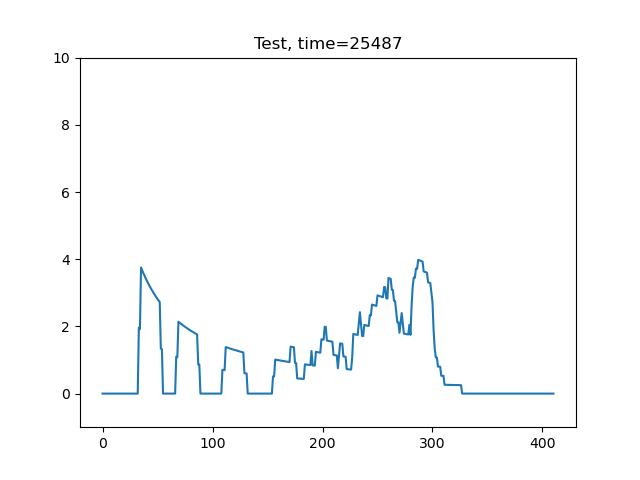

In [37]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, trial[0])
title = ax.set_title('Test, time=0')
ax.set_ylim(-1, 10)

def animate(frame):
    line.set_ydata(trial[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, frames), interval=5, blit=False)
ani.save('../results/video/rdf_from_centre2.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
plt.close()

In [ ]:
g2_centre = np.array(pd.read_parquet("../data/csv/ref_centre.parquet"))

In [ ]:
g_plot = g2_centre[::30, :].T

timearr = np.linspace(0, 30000, 5)/10
timearr = timearr.astype(int)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
img = ax.imshow(np.log(1 + g_plot))
ax.set_xticks(np.linspace(0, g_plot.shape[1], 5))
ax.set_yticks(np.linspace(0, g_plot.shape[0], 5))
ax.set_xticklabels(timearr)
ax.set_yticklabels(np.linspace(0, 2*rDisk, 5).astype(int))
ax.set_aspect(.6)
fig.colorbar(img)
plt.xlabel("Time [s]")
plt.ylabel("r [px]")
plt.title("$Log(1 + g_2)$ heatmap ")
plt.show()

In [ ]:
frame = 0
coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
kd = KDTree(coords)

In [ ]:
coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
kd = KDTree(coords)

r = 100
a = kd.query_ball_point(centre, r + 20)
b = kd.query_ball_point(centre, r)
print(a)
print('\n')
print(b)
n1 = len(a)
n2 = len(b)

resu = n1-n2
print(resu)

In [ ]:
frame = 0
covMatrix = np.cov(COORDS[frame*nDrops:(frame+1)*nDrops,:])
trace_of_covMatrix = np.trace(covMatrix)
eigenvalues, _ = np.linalg.eigh(covMatrix)
#eigenvalues = np.sort(eigenvalues)[::-1]
#diagCovMatrix = np.diag(eigenvalues)
info = np.zeros(len(eigenvalues))
for i in range(len(eigenvalues)):
    info[i] = np.sum(np.sum(eigenvalues[:i]))
info /= trace_of_covMatrix